<font size="5"> VARIOUS IMPORT FUNCTIONS FOR MODELING AND TEXT PREPROCESSING</font> 

In [2]:
#GETTING A LOT OF WARNINGS FROM UPDATED PYTHON MAINLY DEPRACATION WARNINGS
#pip install pyldavis
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import nltk
import pandas as pd
import numpy as np
import re
import string

import spacy
from spacy import displacy
import en_core_web_sm

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.util import ngrams
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
from textblob import TextBlob

from collections import Counter
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import GridSearchCV

import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

<font size="5"> READING IN DF AND DOING TEXT PREPROCESSING</font> 

In [4]:
df = pd.read_csv("resume_data.csv")

In [5]:
df = df.drop_duplicates()

In [6]:
copy_df = df.copy()

In [7]:
###removing bad formatting
def remove_n(resume):
    resume = resume.replace("\\n", " ")
    return resume

In [100]:
df.Resume = df.Resume.apply(remove_n)

In [8]:
copy_df.Resume = copy_df.Resume.apply(remove_n)

In [9]:
#getting stop words
english = spacy.load('en_core_web_sm')
spacy_stops = english.Defaults.stop_words
#print(spacy_stops)
additional_stop_words = ['resume', 'abc' , 'xae' , 'skill', 'key' , 'major' , 'edu' , 'gpa' , 'bachelor' , 'spring' ,
                        'california' , 'xef' , 'ycmail' , 'com' , 'example' , 'email' , 'career' , 'qualification' , 'template' , 
                        'including' , 'xxxx' , 'xxx' , 'www' , 'american' , 'verb' , 'baltimore' , 'illinois' , 'college' , 'date' , 'time'  
                        , 'project' , 'florida' , 'washington' , 'carolina' , 'north', 'xef', 'tjdetweiler', 'university' , 'job' , 'position'
                         , 'include', 'use', 'employer' , 'cover' , 'good' , 'sure' , 'like' , 'relevant' , 'contact' , 'responsibility' ,
                       'developed' , 'reference' ,  'xxxxxx'  ,  'etc'  ]
spacy_stops = list(spacy_stops) + additional_stop_words

In [10]:
tokenizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = spacy_stops,
                                lowercase = False,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 20)

In [11]:
#lower casing all words in resumes
def lower(resume):
    return resume.lower()

In [12]:
copy_df.Resume = copy_df.Resume.apply(lower)

In [13]:
#LEMMATIZATION STANDARDIZES SIMILAR WORDS I.E SKILLS BECOMES SKILL, WORKING BECOMES WORK
def lemmatization(resume):
    lemmatizer = WordNetLemmatizer()
    lemmat_list = []
    for word in (tokenizer.build_tokenizer()(resume)):
        word = lemmatizer.lemmatize(word)
        lemmat_list.append(word)
    return (" ".join(str(e) for e in lemmat_list))

In [14]:
copy_df.Resume = copy_df.Resume.apply(lemmatization)

In [15]:
#GETTING RID OF MOST NAMED ENTITIES SUCH AS LOCATIONS AND PEOPLES NAMES
NER = spacy.load('en_core_web_sm')
def named_entities(resume):
    
    document = NER(resume)
    org_list = []
    for word in document.ents:
        if word.label_ == "ORG" or word.label_ == "PRODUCT":
            org_list.append(word)

    resume = (" ".join([ent.text for ent in document if not ent.ent_type_ ]) + str(org_list))
    return resume

In [16]:
#THIS TAKES A FEW MINUTES TO RUN
copy_df.Resume = copy_df.Resume.apply(named_entities)

In [17]:
#REMOVING COMMON WORDS SUCH AS "THE, AND, ETC."
def remove_stops(resume):
    words = [word for word in resume.split() if word.lower() not in spacy_stops]
    new_resume = " ".join(words)
    return new_resume

In [18]:
copy_df.Resume = copy_df.Resume.apply(remove_stops)

In [19]:
copy_df = copy_df.reset_index()

In [21]:
#x = copy_df.copy()
#x['test'] = x['lemmatized']

In [22]:
#x.test[0] = lemmatization1(x.test[0]) 


In [23]:
'''
#x['test'] = x.test.apply(lemmatization1)
count = 0
for doc in x.test:
    lemmatization1(doc)
    count += 1
    print(count)
'''

"\n#x['test'] = x.test.apply(lemmatization1)\ncount = 0\nfor doc in x.test:\n    lemmatization1(doc)\n    count += 1\n    print(count)\n"

In [25]:
#MAKING MY DOCUMENT TOPIC MATRIX
doc_topic_tf = tokenizer.fit_transform(copy_df.Resume)
print(doc_topic_tf.shape)

(1075, 2294)


 <font size="5"> TESTING TO FIND OPTIMAL NUMBER OF N TOPICS (IT DIDN'T WORK)</font> 

In [26]:
lda_tf = LatentDirichletAllocation(n_components=12, random_state=42)
lda_tf.fit(doc_topic_tf)

LatentDirichletAllocation(n_components=12, random_state=42)

In [27]:
print("Log Likelihood: ", lda_tf.score(doc_topic_tf))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_tf.perplexity(doc_topic_tf))

# See model parameters
print(lda_tf.get_params())

Log Likelihood:  -2209073.6284395577
Perplexity:  928.0066033813494
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 12, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': 42, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


In [28]:
#THIS TAKES SEVERAL MOMENTS TO RUN
# Define Search Param
search_params = {'n_components': [5, 8, 10, 15, 20], 'learning_decay': [.5, .7, .9]}

# Init Grid Search Class
model = GridSearchCV(lda_tf, param_grid=search_params)

# Do the Grid Search
model.fit(doc_topic_tf)

GridSearchCV(estimator=LatentDirichletAllocation(n_components=12,
                                                 random_state=42),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [5, 8, 10, 15, 20]})

In [29]:
GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       param_grid={'n_topics': [5, 8, 10, 15, 20], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

GridSearchCV(error_score='raise',
             estimator=LatentDirichletAllocation(learning_method=None,
                                                 n_jobs=1),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_topics': [5, 8, 10, 15, 20]},
             return_train_score='warn')

In [30]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(doc_topic_tf))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 5}
Best Log Likelihood Score:  -476821.21796977066
Model Perplexity:  1021.5388841893405


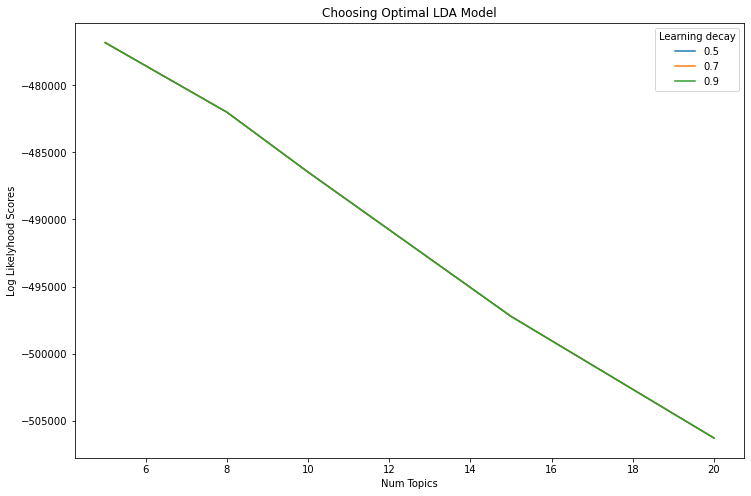

In [31]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [ 5, 8, 10, 15, 20]
log_likelyhoods_5 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.5]
log_likelyhoods_7 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.7]
log_likelyhoods_9 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [ ]:
#SAYING OPTIMAL NUMBER OF TOPICS IS 5? SHOULD BE HIGHER JUST EXAMING THE DOCUMENTS

 <font size="5"> BUILDING AND VISUALIZING TOPIC MODELS</font> 

In [32]:
lda_tf = LatentDirichletAllocation(n_components=25, random_state=16)
lda_tf.fit(doc_topic_tf)

LatentDirichletAllocation(n_components=25, random_state=16)

In [33]:
pyLDAvis.enable_notebook()
vis =pyLDAvis.sklearn.prepare(lda_tf, doc_topic_tf, tokenizer)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
13    -0.115598  0.030679       1        1  8.720337
7      0.234691  0.154155       2        1  8.193843
10     0.098786  0.021172       3        1  7.542176
19     0.007086 -0.012276       4        1  7.048493
21     0.003141 -0.134128       5        1  6.984493
3     -0.176826  0.072251       6        1  6.733794
15    -0.153153 -0.043609       7        1  6.587262
12    -0.113932  0.149697       8        1  5.851628
14    -0.080828 -0.120188       9        1  5.318831
17    -0.120740  0.036242      10        1  4.586992
9     -0.151886  0.067932      11        1  3.596177
20    -0.127568  0.015441      12        1  3.235004
5     -0.057408 -0.060690      13        1  3.140030
0     -0.033243 -0.105366      14        1  2.909743
23     0.008322  0.105355      15        1  2.620072
16    -0.112613  0.127017      16        1  2.563180
24     0.113364  0.085334      17        1  2.472267
18     0.176488 -0.060818      18        1  2.469956
6      0.032571 -0.214115      19        1  2.414370
8      0.129410 -0.005210      20        1  1.465662
2      0.095389  0.200600      21        1  1.293258
1      0.250735 -0.009940      22        1  1.271007
22    -0.026005 -0.130949      23        1  1.030695
4      0.018872 -0.097524      24        1  1.018007
11     0.100948 -0.071062      25        1  0.932724, topic_info=           Term         Freq        Total Category  logprob  loglift
594      design  1879.000000  1879.000000  Default  30.0000  30.0000
1199        law  1197.000000  1197.000000  Default  29.0000  29.0000
1869       sale  1964.000000  1964.000000  Default  28.0000  28.0000
863   financial  1136.000000  1136.000000  Default  27.0000  27.0000
146         art   780.000000   780.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
1984      space    17.934600   195.318800  Topic25  -5.1248   2.2869
310      center    23.363383   804.555722  Topic25  -4.8603   1.1357
628    director    22.268667   621.591679  Topic25  -4.9083   1.3457
341       child    20.792628   463.456847  Topic25  -4.9769   1.5707
1004       high    22.397860   893.652761  Topic25  -4.9025   0.9885

[1405 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.077273  ability
0         3  0.010017  ability
0         4  0.064394  ability
0         5  0.002862  ability
0         6  0.289059  ability
...     ...       ...      ...
2289     12  0.831397      yes
2289     13  0.148464      yes
2293      1  0.095417      zip
2293      4  0.834901      zip
2293     16  0.047709      zip

[9188 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 8, 11, 20, 22, 4, 16, 13, 15, 18, 10, 21, 6, 1, 24, 17, 25, 19, 7, 9, 3, 2, 23, 5, 12])

In [34]:
vis_df = vis.topic_info
vis_df = vis_df.drop(vis_df[vis_df.Category == "Default"].index)

In [125]:
vis_df.sort_values(by = 'Category', ascending = False).head()

,Term,Freq,Total,Category,logprob,loglift
2199,user,338.849325,535.232971,Topic9,-3.9268,2.4768
1693,prototype,32.570722,56.209948,Topic9,-6.2690,2.3882
1124,interface,96.199566,177.125876,Topic9,-5.1860,2.3235
907,framework,76.943236,142.014835,Topic9,-5.4093,2.3211
1031,html,109.180611,212.050358,Topic9,-5.0594,2.2701


In [36]:
###testing idf did not like the results. Topics much harder to distinguish
'''
tfidf_vectorizer = TfidfVectorizer(**tokenizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(copy_df.Resume)
lda_tfidf = LatentDirichletAllocation(n_components=5, random_state=5)
lda_tfidf.fit(dtm_tfidf)
'''

'\ntfidf_vectorizer = TfidfVectorizer(**tokenizer.get_params())\ndtm_tfidf = tfidf_vectorizer.fit_transform(copy_df.Resume)\nlda_tfidf = LatentDirichletAllocation(n_components=5, random_state=5)\nlda_tfidf.fit(dtm_tfidf)\n'

In [37]:
#pyLDAvis.sklearn.prepare(lda_tfidf, dtm_tfidf, tfidf_vectorizer)

In [38]:
#BUILDING OUT MY TOPIC DOCUMENT DF
topic_doc_df = pd.DataFrame(lda_tf.transform(doc_topic_tf))
topic_doc_df.head()
topic_doc_df["resume"] = copy_df.Resume.copy()


In [39]:
#0 - automotives?
#1 - painter/art_exhibitionist
#2 - accounting/taxes
#3 - banking/finance
#4 - film/entertainment/acting
#5 - business_administration?
#6 - graphic design
#7 - health/administration
#8 - hospitality
#9 - human_resources/payroll
#10 - teacher/educational_staff
#11 - interior_design/architecture
#12 - management/upper_executive
#13 - sales/marketing
#14 - frontend_dev/app_dev
#15 - data_analyst/DB_admin
#16 - investor
#17 - construction
#18 - social_media_specialist/digital_marketing
#19 - mentor/guidance_conselor/academic_advisor
#20 - (templates)
#21 - mechanical_electrical_engineer
#22 - fashion_designer/photographer
#23 - lawyer
#24 - doctor/nurse/hospital_worker

topic_list = ['automotives?' , 'painter/art_exhibitionist' , 'accounting/taxes' , 'banking/finance' , 'film/entertainment/acting' 
             , 'business_administration?' , 'graphic design' , 'health/administration' , 'hospitality' , 'human_resources/payroll' , 
            'teacher/educational_staff' , 'interior_design/architecture' , 'management/upper_executive' , 'sales/marketing', 
              'frontend_dev/app_dev', 'data_analyst/DB_admin', 'investor' , 'construction' , 'social_media_specialist/digital_marketing' ,
            'mentor/guidance_conselor/academic_advisor' , 'templates' , 'mechanical_electrical_engineer' , 'fashion_designer/photographer',
            'lawyer' , 'doctor/nurse/hospital_worker' ]

In [40]:
for i in range(25):
    topic_doc_df = topic_doc_df.rename(columns={i: topic_list[i]})

In [41]:
topic_doc_df.head()

,automotives?,painter/art_exhibitionist,accounting/taxes,banking/finance,film/entertainment/acting,business_administration?,graphic design,health/administration,hospitality,human_resources/payroll,...,investor,construction,social_media_specialist/digital_marketing,mentor/guidance_conselor/academic_advisor,templates,mechanical_electrical_engineer,fashion_designer/photographer,lawyer,doctor/nurse/hospital_worker,resume
0,0.000099,0.000099,0.000099,0.020395,0.000099,0.000099,0.000099,0.032847,0.000099,0.083842,...,0.000099,0.019382,0.000099,0.000099,0.055496,0.000099,0.000099,0.000099,0.009043,info greatresumesfast approachable innovator p...
1,0.198660,0.000417,0.000417,0.000417,0.000417,0.000417,0.000417,0.000417,0.000417,0.154366,...,0.000417,0.000417,0.000417,0.000417,0.556685,0.000417,0.000417,0.081538,0.000417,surname address mobile personal profile self m...
2,0.019882,0.000093,0.000093,0.081045,0.000093,0.026611,0.000093,0.000093,0.000093,0.261017,...,0.000093,0.000093,0.000093,0.000093,0.609588,0.000093,0.000093,0.000093,0.000093,assistant area expertise personal summary proc...
3,0.037071,0.000074,0.000074,0.000074,0.000074,0.018197,0.017169,0.000074,0.000074,0.523987,...,0.000074,0.000074,0.012032,0.000074,0.000074,0.000074,0.000074,0.000074,0.000074,objective pursue growth oriented progressive c...
4,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.086853,...,0.000098,0.000098,0.000098,0.000098,0.022676,0.000098,0.000098,0.025380,0.000098,human resource director organizational effecti...


In [42]:
topic_doc_df.sort_values(by = 'human_resources/payroll' , ascending = False).head()

,automotives?,painter/art_exhibitionist,accounting/taxes,banking/finance,film/entertainment/acting,business_administration?,graphic design,health/administration,hospitality,human_resources/payroll,...,investor,construction,social_media_specialist/digital_marketing,mentor/guidance_conselor/academic_advisor,templates,mechanical_electrical_engineer,fashion_designer/photographer,lawyer,doctor/nurse/hospital_worker,resume
29,0.000115,0.000115,0.000115,0.000115,0.000115,0.000115,0.000115,0.000115,0.000115,0.855958,...,0.000115,0.035222,0.000115,0.000115,0.000115,0.018473,0.000115,0.000115,0.000115,seeking asst managerial human resource adminis...
5,0.000090,0.000090,0.000090,0.000090,0.000090,0.000090,0.000090,0.000090,0.000090,0.845691,...,0.000090,0.000090,0.000090,0.000090,0.000090,0.000090,0.000090,0.000090,0.000090,experience senior corporate wipro technology y...
28,0.000073,0.000073,0.000073,0.000073,0.000073,0.000073,0.000073,0.000073,0.000073,0.835003,...,0.000073,0.000073,0.000073,0.000073,0.000073,0.000073,0.000073,0.000073,0.000073,seeking middle level managerial assignment hum...
13,0.108843,0.000092,0.000092,0.000092,0.000092,0.000092,0.000092,0.000092,0.000092,0.823249,...,0.000092,0.000092,0.002664,0.000092,0.000092,0.000092,0.000092,0.000092,0.000092,summary year total experience playing role fun...
111,0.038787,0.000149,0.000149,0.000149,0.000149,0.000149,0.000149,0.000149,0.011412,0.755055,...,0.000149,0.000149,0.005215,0.000149,0.051717,0.000149,0.000149,0.000149,0.000149,gmail aspiring challenging assignment human re...


In [43]:
#MAKING TERM TOPIC DF
term_topic_df = pd.DataFrame(lda_tf.components_, columns = tokenizer.get_feature_names()).T

In [44]:
for i in range(25):
    term_topic_df = term_topic_df.rename(columns={i: topic_list[i]})

In [45]:
#WORDS 'EMPLOYEE, RECRUITMENT, TRAINING PLAY A STRONG ROLL IN HR RESUMES'
term_topic_df.sort_values(by = 'human_resources/payroll' , ascending = False).head()

,automotives?,painter/art_exhibitionist,accounting/taxes,banking/finance,film/entertainment/acting,business_administration?,graphic design,health/administration,hospitality,human_resources/payroll,...,data_analyst/DB_admin,investor,construction,social_media_specialist/digital_marketing,mentor/guidance_conselor/academic_advisor,templates,mechanical_electrical_engineer,fashion_designer/photographer,lawyer,doctor/nurse/hospital_worker
employee,0.040000,0.04000,0.040000,54.410102,0.040000,0.040000,0.040000,2.953956,0.040000,405.831908,...,14.959509,0.040000,27.773057,4.616212,45.360228,0.040000,3.485908,4.366632,0.041877,0.044117
recruitment,0.040000,0.04000,1.747020,0.040000,2.304627,0.040000,0.040000,6.620128,0.746513,188.521531,...,0.040000,0.040000,0.040000,0.248790,8.975925,7.795629,0.040000,0.040000,0.040000,0.219281
training,116.506062,0.04000,3.415194,54.049400,16.591613,3.608470,4.860364,146.724823,9.988986,174.270199,...,52.415918,0.040000,193.385255,11.728345,9.348789,3.076925,3.844223,4.950787,9.291006,6.716737
manager,0.108504,0.04000,0.324966,197.289742,31.293534,14.898256,6.530076,2.866180,21.077036,140.355385,...,80.200166,66.587740,146.875247,14.803508,10.407235,71.351502,14.966205,4.439873,27.054389,2.507698
process,2.022789,2.27066,0.488566,52.352189,0.040000,34.232487,5.846207,4.120742,8.442617,119.623157,...,316.003791,38.911292,40.268938,0.040000,6.359939,13.688047,57.042679,13.916017,26.128909,0.040000


In [46]:
#term_topic_df.sort_values(by = 5, ascending = False).head(100).index

In [61]:
len(topic_doc_df)

1075

In [63]:
topic_doc_df = topic_doc_df.drop_duplicates()

In [64]:
topic_doc = topic_doc_df.copy()

In [65]:
topic_doc = topic_doc.drop(columns = 'resume')

In [49]:
'''
t = ["planning tax cpa accounting"]
vt = tokenizer.transform(t)

tt = lda_tf.transform(vt)

array = pairwise_distances(tt,topic_doc,metric='cosine').argsort()


l = array[0][:5]
'''

'\nt = ["planning tax cpa accounting"]\nvt = tokenizer.transform(t)\n\ntt = lda_tf.transform(vt)\n\narray = pairwise_distances(tt,topic_doc,metric=\'cosine\').argsort()\n\n\nl = array[0][:5]\n'

<font size="5"> BUILDING THE FILTER </font> 

In [89]:
#TAKES IN A JOB DESCRIPTION RETURNS TOP 5 MOST QUALIFIED RESUMES
def job_description(description):
    text = [description]
    token_text = tokenizer.transform(text)
    transformed_text = lda_tf.transform(token_text)
    array = (pairwise_distances(transformed_text ,topic_doc,metric='cosine').argsort())
    top_5 = array[0][:5]
    top_resume_df = pd.DataFrame()
    top_resume_df["resume"] = topic_doc_df.resume[top_5]
    return top_resume_df
    #return array
    

In [91]:
#SOFTWARE DEVELOPER JOB DESCRIPTION PULLED FROM INDEED

jd_cs = "jd = VariVerge, LLC (sister company of Panhandle, Presort Services, Ltd) is looking for a highly motivated person with a background/education in computer science/programming. VariVerge, LLC is a printing and mailing company specializing in high speed variable data printing for banks, utilities, tax assessor-collectors and tax appraisal districts. We specialize in processing incoming data into print ready files, then inserting printed material into a mailing envelope and submitting to United States Postal Service. We use batch scripting to automate the processing of customer data. Pay range is 60,000-100,000 depending on experience and skill set brought to the table. We are interested in young professionals fresh out of college to seasoned experienced persons with multiple years of IT/programming experience. Requirements: Bachelor’s Degree in Computer Science Preferred 2-3 years industry experience at least Knowledge of Computer Languages such as SQL Python VB.net JavaScript Command Line/Batch Processing C++ and C# Goals for this position: Learn and understand each piece of software involved in the process. Software use involves GUI’s as well as traditional line programming. Develop a clear understanding for all the moving parts in our process in order to effectively trouble shoot problems as well as identify areas for improvement Manage and coordinate all parties involved in changes and make necessary process changes Assist management in the implementation of a better change management coding process for current applications. Assist management in converting existing application to web-based applications hosted in Microsoft's Azure Platform Assist management in the implementation support ticket system to be used by external customers are well as internal issues. Responsibilities: Understand our data processing procedures How we receive data from outside customers Process data using various software’s Learn various Software’s DOC1 Streamweaver BCC Mail Manager Uluro by Transformations Identify bottlenecks, through inquiry, that could be programmatically eliminated Assist in Job Level Documentation Coordinate and ensure necessary changes are made Understand and research mail.dat/Full Service IMB (Intelligent Mail Barcode) as well as other Usps mailing standards in effort to understand postal rules and regulations Attention to detail Works well in a team Problem Solver Task Oriented Learn more about what we do. [website] [website] Job Type: Full-time Salary: $62,000.00 to $92,000.00 /year Experience: similar: 5 years (Preferred) Education: Bachelor's (Preferred) Additional Compensation: Bonuses Work Location: One location Benefits: Health insurance Retirement plan Paid time off Professional development assistance Visa Sponsorship Potentially Available: No: Not providing sponsorship for this job Schedule: Monday to Friday Company's website: Temporarily due to Covid-19"

In [84]:
#LAWYER JOB DESCRIPTION PULLED FROM LAW OFFICE SITE THAT WAS HIRING

jd_l = 'We are looking to hire a lawyer with brilliant research and analytical skills. Lawyers are expected to display sound judgment and decision-making with outstanding problem-solving and communication skills.To ensure success, lawyers should be determined, professional and well informed with a keen interest in upholding the law while protecting a client’s rights. Top candidates will display natural leadership qualities with fantastic interpersonal, written and public speaking skills.Lawyer Responsibilities:Monitor legal risk in documentation and giving guidance on the acceptable assumption of risk.Interpret laws, rulings and regulations for natural and juristic persons.Conduct legal research and gather evidence.Ensure that appropriate approvals are in place before documents are executed.Explain the law and give legal advice.Offer legal representation at arbitration or mediation hearings.Draft, review and manage wills, trusts, estates, contracts and deeds.Manage regulatory and compliance-related services.Facilitate innovative solutions to client problems.Offer legal representation to clients in court proceedings on civil or criminal matters.Manage and oversee paralegals and legal assistants.Prepare pleadings, notices and make appearances in court.Lawyer Requirements:Bachelors degree in law (essential).dmitted attorney of at least two years standing.Experience in drafting, negotiating and reviewing legal documents.Analytical thinker with strong conceptual and research skills.Natural leader who displays sound judgment and attention to detail.Ability to work under pressure and meet deadlines.Ability to work independently and as part of a team.Excellent interpersonal, communication and public speaking skills.'

In [90]:
job_description(jd_l)

,resume
353,phd attorney law curriculum vitae sondra gmail...
382,curriculum vitae professional experience prese...
342,sample immigration attorney street ardmore add...
375,main heading large font size harvey hill rose ...
338,curriculum secretary general international civ...


In [136]:
#lemmatization(copy_df.Resume[353])
copy_df.Resume[353]

'sample immigration attorney street ardmore address telephone number objective looking immigration attorney knowledge help people legality immigration summary posse prior experience working immigration attorney communication better work management management expertise verbal communication law work management leadership worker professional experience firm attorney duration task immigration texas county immigration attorney aspect immigrant visa pas port immigration office county handle immigration issue academic history declaration declare information provided true knowledge furnished request[the texas immigration office posse excellent, knowledge immigration rule, texas immigration office post immigration, team junior, university, social law, high school, saint laurent international high school]'

In [92]:
job_description(jd_cs)

,resume
166,area expertise commercial experience web devel...
206,therealjoshua objective developer software arc...
159,pramod gmail experience web application develo...
907,main street new cell mail summary result orien...
612,mba pmp senior manager program manager managem...


In [128]:
lemmatization(df.Resume[206])

'Andrii Chernenko Mobile Application Developer EDUCATION Period Name Dept Degree Odesa National Polytechnic University Institute Computer Systems Software Engineering Master degree Place Odesa Ukraine Present Linnaeus University School Computer Science Software Engineering Second Master degree exchange program Sweden SKILLS Programming Languages Technologies Name Skill Level Java Advanced Android SDK Advanced RESTful web service Advanced iOS Objective Intermediate SQL SQLite Intermediate Selenium Basic JMeter Basic Last Used Experience Current year Current month Current month Current month Current year month month Also some basic knowledge Python PHP Assembler Spring framework Integrated Development Environments IntelliJ IDEA Advanced Xcode Intermediate Eclipse for Java Intermediate Current year Current month month Version Control Systems Git Subversion Advanced Intermediate Current month Current year Bug tracking system Redmine Jira Advanced Intermediate Current year Current month Ope

In [113]:
#after all code has finished this will chime :D 
os.system('say "That was easy"')

0